# XCCY PCA
TL Mar 2019

In [1]:
%load_ext autoreload
%autoreload 2

from pipe import getdata
from pandas.tseries.offsets import BDay

from IPython.core.debugger import Tracer #pdb.set_trace()
import pdb

import statsmodels.tsa.stattools as ts

import random
import time
from itertools import compress
from sklearn.decomposition import PCA

Certain modules were not found which will affect which functions will work. Check if you have OneTick installed and module NumPy_OneTickQuery not found. Also check for win32com which might not work on Linux machines (untested)


Q:\wp\python-3.6.2.amd64\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
## Import data from csv files ##

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

def csv2df(csvName):
    
    # Import and format CSV as df
    # See spotEUR.csv for formatting template
    
    dfOut = pd.read_csv(csvName, parse_dates=[0],
                        infer_datetime_format=True, dayfirst=True)
    
    dfOut['Date'] = pd.to_datetime(dfOut['Date'])
    dfOut.set_index('Date', inplace=True)
    dfOut = dfOut.sort_index() # Sort chronologically
    
    return dfOut

In [3]:
## Stat analysis functions ##

def runStats(dfInput, nCol):
    
    dfRets = dfInput.diff()*100 # Daily returns in bps
    dfRets = dfRets.dropna() # First row is NaN, gets dropped, any others too
    
    colNames = dfRets.columns.get_values()
    colNames[nCol]
    
    retRange = dfRets[colNames[nCol]].max()-dfRets[colNames[nCol]].min()

    dfRets[colNames[nCol]].plot(kind='hist',bins=int(retRange),title=colNames[nCol])
    
    return print(colNames[nCol],"\n",
                 'range',retRange,"\n",
                 'mean',np.round(dfRets[colNames[nCol]].mean(),3),"\n",
                 'sigma',np.round(dfRets[colNames[nCol]].std(),3))

In [4]:
## PC Analysis (rolling window) ##

def pcaRun(dfPar):
    
    dfRets = dfPar.diff()*100 # Daily returns in bps
    dfRets = dfRets.dropna() # First row is NaN, gets dropped, any others too
    
    from scipy import stats
    dfRets_o = dfRets[(np.abs(stats.zscore(dfRets)) < 3).all(axis=1)] # Remove 3 sigma outliers
    
    cols = dfRets_o.shape[1]
    pca = PCA(n_components=cols)
    
    eigenVal = []
    eigenVec = []

    sampleSize = dfRets_o.shape[0]
    lookbackSize = 90
    
    for i in range(0,(sampleSize-lookbackSize)):
        #print(i,lookbackSize+i)
        pca.fit(dfRets_o.iloc[i:lookbackSize+i])
        eigenVal.append(pca.explained_variance_ratio_)
        eigenVec.append(pca.components_)
        
    dfPC1 = pd.DataFrame().reindex_like(dfRets_o)
    dfPC1 = dfPC1.iloc[lookbackSize:]
    
    for n in range(0,len(eigenVec)):
        for k in range(0,len(eigenVec[0][0])):
            dfPC1.iloc[n,k] = np.abs(eigenVec[n][0][k])
        
    return dfPC1

def pcaPlot(dfLoad, nDays, firstTenor=0, lastTenor='', mySize=(14,10)):
    
    if lastTenor=='':
        lastTenor = dfLoad.shape[1]
    
    return dfLoad.iloc[dfLoad.shape[0]-nDays:,
                       firstTenor:lastTenor].plot(legend=True,
                                                  figsize=mySize,
                                                  grid=True,
                                                  colormap='rainbow')

In [5]:
## Time series plotting functions ##

def curvePlot(dfInput, nDays, sLong, sShort, mySize=(14,5)):
    
    dfSpread = pd.DataFrame()
    dfSpread = (dfInput[sLong + ' Par Swap Rate']-dfInput[sShort + ' Par Swap Rate'])*100
    
    axSpread = dfSpread.iloc[dfSpread.shape[0]-nDays:].plot(legend=False,
                                                            figsize=mySize,
                                                            title='Curve '+sShort+'/'+sLong,
                                                            grid=True)
    return axSpread

def flyPlot(dfInput, nDays, wing1, belly, wing2, mySize=(14,5)):
    
    dfFly = pd.DataFrame()
    dfFly = ((2*dfInput[belly + ' Par Swap Rate'])
             -dfInput[wing1 + ' Par Swap Rate']
             -dfInput[wing2 + ' Par Swap Rate'])*100
    
    axFly = dfFly.iloc[dfSpread.shape[0]-nDays:].plot(legend=False,
                                                      figsize=mySize,
                                                      title='Fly '+wing1+'/'+belly+'/'+wing2,
                                                      grid=True)
    return axFly

In [6]:
## Column renaming function ##

def renameCol(dfInput,removeString=' Fwd Swap Rate'):
    
    test = dfInput.columns.get_values()
    
    for x in range(0,len(test)):
        test[x] = test[x].replace(removeString,'')
        
    dfInput.columns = test
    
    return dfInput

In [7]:
from sklearn.decomposition import PCA

def pcaRes(dfCross,trainSize,testSize):
    
    pca = PCA(n_components=3) #n_components=3
    
    m = trainSize # training set size
    n = testSize # test set size
    
    trainSet = dfCross.iloc[dfCross.shape[0]-n-m:dfCross.shape[0]-n] # Need a way to loop thru the entire sample
    testSet = dfCross.iloc[dfCross.shape[0]-n:]
    
    # Train model
    pca.fit(trainSet)

    # Regen rates from model both in and out of sample
    inSample = pca.transform(trainSet)
    outSample = pca.transform(testSet) #pd.DataFrame(pca.transform(testSet)).set_index(testSet.index)
    
    inRes = trainSet - pca.inverse_transform(inSample)
    outRes = testSet - pca.inverse_transform(outSample)
    
    return inRes, outRes

In [8]:
from sklearn.linear_model import LinearRegression

def costSlope(dfInput,plot=False):
    
    model = LinearRegression(fit_intercept=True)
    
    cols = dfInput.columns.get_values()
    x = np.arange(dfInput.shape[0])
    slope = []
    cost = []
    
    for i in range(0,dfInput.shape[1]):
        
        y = dfInput[cols[i]].values
        
        model.fit(x[:, np.newaxis], y)
        xfit = np.linspace(0, dfInput.shape[0], 1000)
        yfit = model.predict(xfit[:, np.newaxis])
        
        slope.append(model.coef_[0])
        cost.append(np.round(np.abs(model.coef_[0])-0.01,5))
               
        if plot==True:
            plt.scatter(x, y)
            plt.plot(xfit, yfit)
        
    return slope, cost

5Y EUR/USD Basis Swap Spread 
 range 812.49 
 mean 0.453 
 sigma 77.6


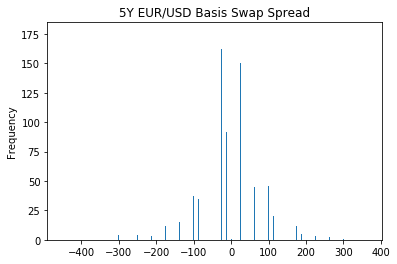

In [12]:
dfdummy = csv2df('eurusdPar.csv')

from scipy import stats
dfdumdum = dfdummy[(np.abs(stats.zscore(dfdummy)) < 3).all(axis=1)]

runStats(dfdumdum,9)

plt.show()

In [9]:
# Data import
dfTest = renameCol(csv2df('eurusdFwdnew.csv'),' Basis Fwd Swap Spread')
dfTest = dfTest.dropna()

In [10]:
## PCA param optimization

training = np.arange(200)
test = np.arange(60)

outCost = np.random.rand(len(training),len(test))

#dfOut = pd.DataFrame({'trainSize':[],'testSize':[],'Cost':[]})

for i in range(3,len(training)):
    
    for j in range(1,len(test)):
        
        myRes = pcaRes(dfTest,training[i],test[j])
        outCost[i,j] = (np.mean(costSlope(myRes[1])[1]))
        #outCost.append(np.mean(costSlope(myRes[1])[1]))

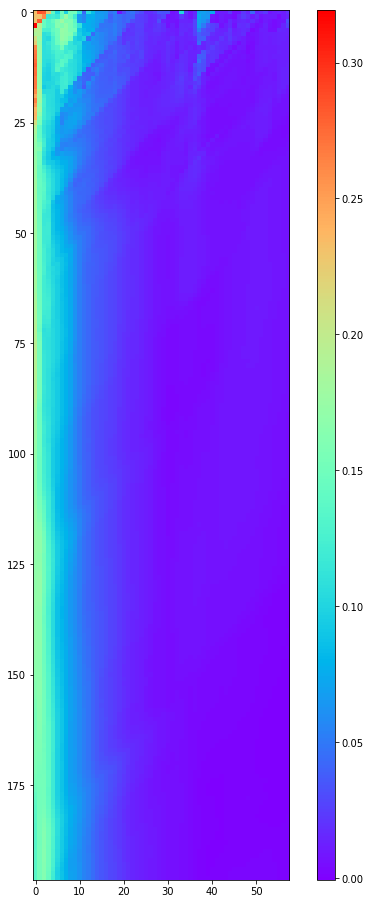

In [40]:
fig = plt.figure(figsize=(10,16))
plt.imshow(outCost[3:,2:], cmap='rainbow')
plt.colorbar(shrink=1, aspect=50)
plt.show()

-0.006936
0.006035


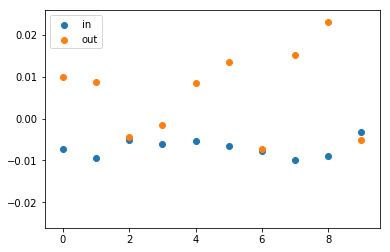

In [34]:
inSlope, inCost = costSlope(inRes)
outSlope, outCost = costSlope(resid)

print(np.mean(inCost))
print(np.mean(outCost))

plt.scatter(np.arange(len(inCost)),inCost,label='in')
plt.scatter(np.arange(len(outCost)),outCost,label='out')
plt.legend(loc='best')
plt.show()

In [37]:
## PCA for XCCY curve

# Data import
dfCross = renameCol(csv2df('eurusdFwdnew.csv'),' Basis Fwd Swap Spread')
dfCross = dfCross.dropna()
cols = dfCross.shape[1]

# Model setup
from sklearn.decomposition import PCA
pca = PCA(n_components=3) #n_components=3

n = 50 # test set size
m = 150 # training set size
trainSet = dfCross.iloc[dfCross.shape[0]-n-m:dfCross.shape[0]-n]
testSet = dfCross.iloc[dfCross.shape[0]-n:]

fullSet = dfCross.iloc[dfCross.shape[0]-n-m:]

# Train model
pca.fit(trainSet)

# Regen rates from model both in and out of sample
inSample = pca.transform(trainSet)
outSample = pca.transform(testSet) #pd.DataFrame(pca.transform(testSet)).set_index(testSet.index)

print(np.cumsum(pca.explained_variance_ratio_))

[ 0.83748001  0.94209006  0.96474127]


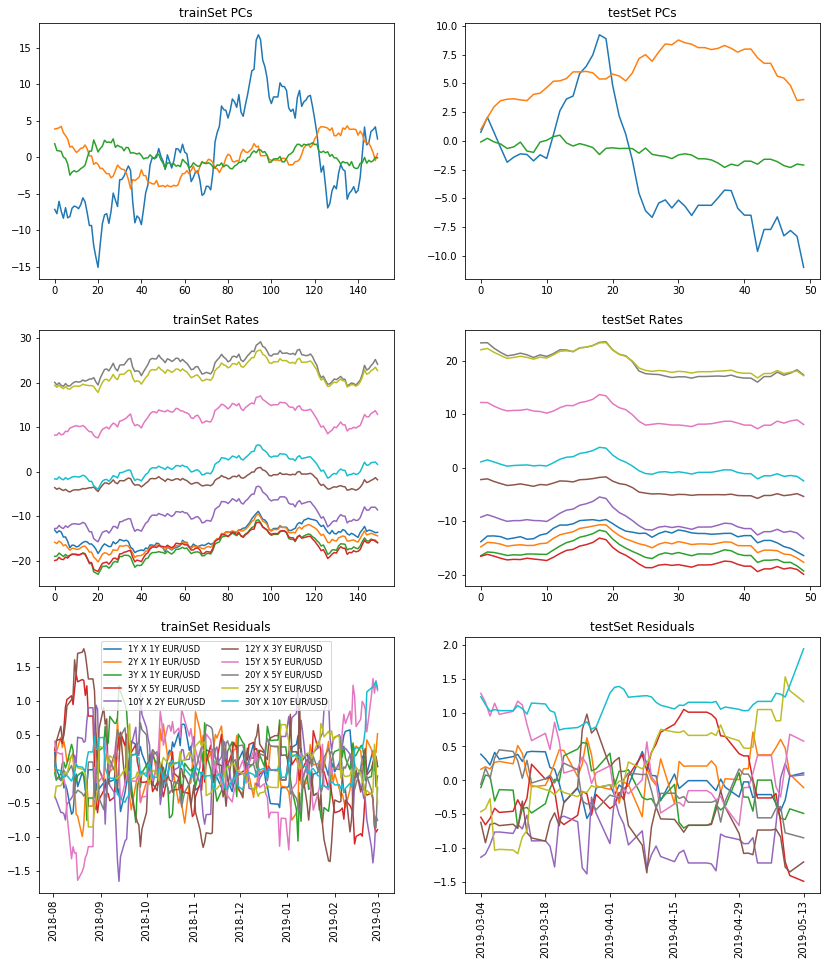

In [38]:
# Plotting results of above test

fig = plt.figure(figsize=(14,16)) #figsize=(12,10)
fig.add_axes()

ax1 = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
ax5 = fig.add_subplot(325)
ax6 = fig.add_subplot(326)

ax1.plot(inSample)
ax1.set_title('trainSet PCs')
#ax1.tick_params(labelbottom=False)

ax2.plot(outSample)
ax2.set_title('testSet PCs')

ax3.plot(pca.inverse_transform(inSample))
ax3.set_title('trainSet Rates')

ax4.plot(pca.inverse_transform(outSample))
ax4.set_title('testSet Rates')

inRes = trainSet - pca.inverse_transform(inSample)
outRes = testSet - pca.inverse_transform(outSample)

ax5.plot(inRes)
ax5.set_title('trainSet Residuals') # Implement test for mean reversion
ax5.legend(inRes.columns.get_values(),loc='best',ncol=2,fontsize='small')
for tick in ax5.get_xticklabels():
    tick.set_rotation(90)

ax6.plot(outRes)
ax6.set_title('testSet Residuals')

for tick in ax6.get_xticklabels():
    tick.set_rotation(90)

plt.show()

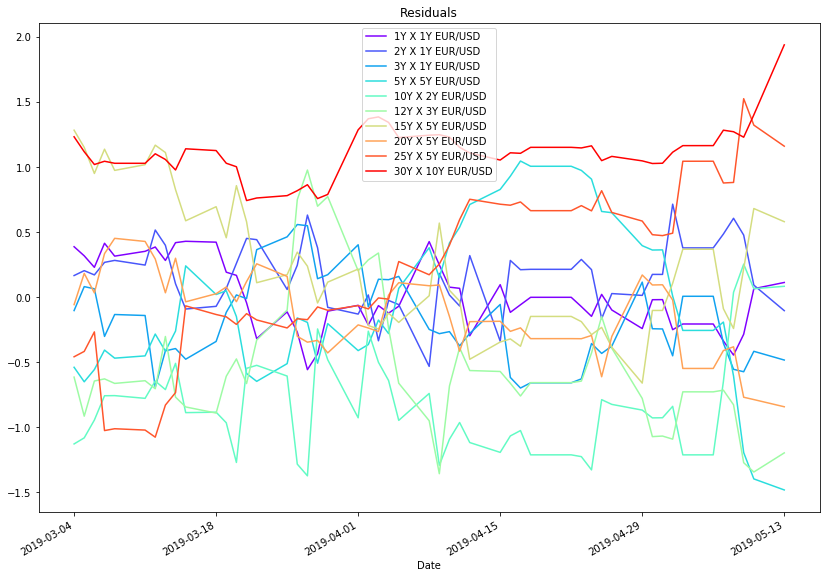

In [39]:
reconOut = pca.inverse_transform(outSample)
resid = testSet - reconOut

resid.plot(legend=True,colormap='rainbow',figsize=(14,10),title='Residuals')
plt.show()

5Y X 5Y EUR/USD
Model slope:     -0.00840199086318
Model intercept: 1.28468256241


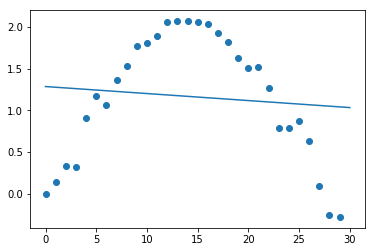

In [94]:
### Fit line to residuals time series - TEST ###

from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)

x = np.arange(resid.shape[0])
y = resid['5Y X 5Y EUR/USD'].values

#y2 = resid['3Y X 1Y EUR/USD'].values

model.fit(x[:, np.newaxis], y)

xfit = np.linspace(0, resid.shape[0], 1000)
yfit = model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit)
print('5Y X 5Y EUR/USD')
print("Model slope:    ", model.coef_[0])
print("Model intercept:", model.intercept_)
plt.show()

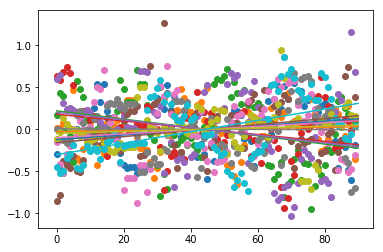

In [92]:
### Fit line to residuals time series ###

from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)

dfInput = inRes
cols = dfInput.columns.get_values()

x = np.arange(dfInput.shape[0])

in_slope = []

for i in range(0,dfInput.shape[1]):
    
    y = dfInput[cols[i]].values
    
    model.fit(x[:, np.newaxis], y)
    xfit = np.linspace(0, dfInput.shape[0], 1000)
    yfit = model.predict(xfit[:, np.newaxis])
    
    in_slope.append(model.coef_[0])
    
    #print(cols[i])
    #print("Model slope:    ", model.coef_[0])
    #print("Model intercept:", model.intercept_,'\n')
    
    plt.scatter(x, y)
    plt.plot(xfit, yfit)

plt.show()

1Y X 1Y EUR/USD
Model slope:     -0.01995 False
Slope cost funct: 0.00995
2Y X 1Y EUR/USD
Model slope:     0.01869 False
Slope cost funct: 0.00869
3Y X 1Y EUR/USD
Model slope:     -0.00568 True
Slope cost funct: -0.00432
5Y X 5Y EUR/USD
Model slope:     -0.0084 True
Slope cost funct: -0.0016
10Y X 2Y EUR/USD
Model slope:     0.01846 False
Slope cost funct: 0.00846
12Y X 3Y EUR/USD
Model slope:     -0.02354 False
Slope cost funct: 0.01354
15Y X 5Y EUR/USD
Model slope:     0.00276 True
Slope cost funct: -0.00724
20Y X 5Y EUR/USD
Model slope:     -0.02507 False
Slope cost funct: 0.01507
25Y X 5Y EUR/USD
Model slope:     0.03293 False
Slope cost funct: 0.02293
30Y X 10Y EUR/USD
Model slope:     0.00487 True
Slope cost funct: -0.00513


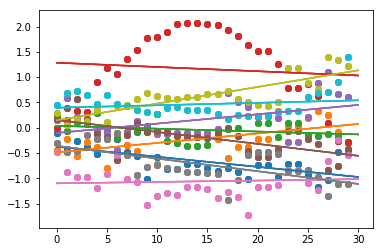

In [90]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)

dfInput = resid
cols = dfInput.columns.get_values()

x = np.arange(dfInput.shape[0])

out_slope = []

for i in range(0,dfInput.shape[1]):
    
    y = dfInput[cols[i]].values
    
    model.fit(x[:, np.newaxis], y)
    xfit = np.linspace(0, dfInput.shape[0], 1000)
    yfit = model.predict(xfit[:, np.newaxis])
    
    out_slope.append(model.coef_[0])
    
    print(cols[i])
    print("Model slope:    ", np.round(model.coef_[0],5),model.coef_[0]>-0.01 and model.coef_[0]<0.01)
    print("Slope cost funct:", np.round(np.abs(model.coef_[0])-0.01,5))
    #print("Model intercept:", model.intercept_,'\n')
    
    plt.scatter(x, y)
    plt.plot(xfit, yfit)

plt.show()

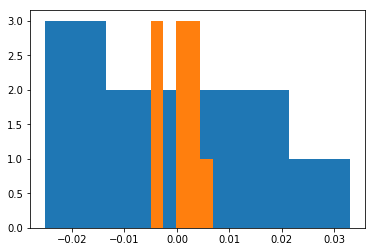

In [59]:
plt.hist(out_slope,5,label='out')
plt.hist(in_slope,5,label='in')
plt.show()

### Notes: reject residual if -0.01 > slope > 0.01

In [25]:
### In sample residual stats ###

inRes # In sample residuals

cols = inRes.columns.get_values()
n = 1
inRes[cols[n]].plot(kind='hist',bins=15,title=cols[n])
#plt.show()

from scipy import stats

cols = inRes.columns.get_values()
tstat = []
pval = []

# Import the Time Series library
import statsmodels.tsa.stattools as ts

# Output the results of the Augmented Dickey-Fuller test for Google
# with a lag order value of 1

lag = 10 # Time ranges to consider 1,2,3,5,10,20,30

for i in range(0,inRes.shape[1]):
    
    print(cols[i],'w/ lag of',lag)
    
    tstat.append(stats.shapiro(inRes[cols[i]].values)[0])
    pval.append(stats.shapiro(inRes[cols[i]].values)[1])
    print('Normality',stats.shapiro(inRes[cols[i]].values)[1]>0.05) #Null accepted if p>0.05 and if Normal
    print('Mean',np.round(np.mean(inRes[cols[i]]),5))
    print('pval',stats.shapiro(inRes[cols[i]].values)[1])
    
    print('Mean rev likely @ 5% c.l.',ts.adfuller(inRes[cols[i]], lag)[1]<0.05,'\n')

1Y X 1Y EUR/USD w/ lag of 10
Normality True
Mean 0.0
pval 0.6202765703201294
Mean rev likely @ 5% c.l. True 

2Y X 1Y EUR/USD w/ lag of 10
Normality True
Mean -0.0
pval 0.5771496891975403
Mean rev likely @ 5% c.l. True 

3Y X 1Y EUR/USD w/ lag of 10
Normality True
Mean -0.0
pval 0.2368571013212204
Mean rev likely @ 5% c.l. True 

5Y X 5Y EUR/USD w/ lag of 10
Normality False
Mean 0.0
pval 0.00032735575223341584
Mean rev likely @ 5% c.l. True 

10Y X 2Y EUR/USD w/ lag of 10
Normality False
Mean 0.0
pval 0.027401935309171677
Mean rev likely @ 5% c.l. True 

12Y X 3Y EUR/USD w/ lag of 10
Normality False
Mean 0.0
pval 1.4705763078382006e-06
Mean rev likely @ 5% c.l. False 

15Y X 5Y EUR/USD w/ lag of 10
Normality True
Mean -0.0
pval 0.2291952669620514
Mean rev likely @ 5% c.l. False 

20Y X 5Y EUR/USD w/ lag of 10
Normality False
Mean -0.0
pval 2.4876905868609356e-08
Mean rev likely @ 5% c.l. False 

25Y X 5Y EUR/USD w/ lag of 10
Normality False
Mean 0.0
pval 0.005125352647155523
Mean rev l

In [26]:
### Out of sample residual stats ###
cols = resid.columns.get_values()
n = 1
resid[cols[n]].plot(kind='hist',bins=15,title=cols[n])
#plt.show()

from scipy import stats

cols = resid.columns.get_values()
tstat = []
pval = []

# Import the Time Series library
import statsmodels.tsa.stattools as ts

# Output the results of the Augmented Dickey-Fuller test for Google
# with a lag order value of 1

lag = 10

for i in range(0,resid.shape[1]):
    
    print(cols[i],'w/ lag of',lag)
    
    tstat.append(stats.shapiro(resid[cols[i]].values)[0])
    pval.append(stats.shapiro(resid[cols[i]].values)[1])
    print('Normality',stats.shapiro(resid[cols[i]].values)[1]>0.05) #Null accepted if p>0.05 and if Normal
    print('Mean',np.round(np.mean(resid[cols[i]]),5))
    print('pval',stats.shapiro(resid[cols[i]].values)[1])
    
    print('Mean rev likely @ 5% c.l.',ts.adfuller(resid[cols[i]], lag)[1]<0.05,'\n')

# Notes of ADF test for mean reversion

# The first value is the calculated test-statistic, while the second value is the p-value. 
# The fourth is the number of data points in the sample. 
# The fifth value, the dictionary, contains the critical values of the test-statistic 
# at the 1, 5 and 10 percent values respectively.

# Since the calculated value of the test statistic is *larger* than any of the critical values 
# at the 1, 5 or 10 percent levels, we cannot reject the null hypothesis of γ=0 and thus we 
# are *unlikely* to have found a mean reverting time series.

1Y X 1Y EUR/USD w/ lag of 10
Normality True
Mean 0.16032
pval 0.5269463062286377
Mean rev likely @ 5% c.l. True 

2Y X 1Y EUR/USD w/ lag of 10
Normality True
Mean -0.02266
pval 0.12286169826984406
Mean rev likely @ 5% c.l. True 

3Y X 1Y EUR/USD w/ lag of 10
Normality True
Mean -0.15357
pval 0.10777092725038528
Mean rev likely @ 5% c.l. True 

5Y X 5Y EUR/USD w/ lag of 10
Normality False
Mean -0.46891
pval 0.003395246574655175
Mean rev likely @ 5% c.l. False 

10Y X 2Y EUR/USD w/ lag of 10
Normality False
Mean -0.10178
pval 0.00010490295971976593
Mean rev likely @ 5% c.l. False 

12Y X 3Y EUR/USD w/ lag of 10
Normality True
Mean -1.06956
pval 0.061536502093076706
Mean rev likely @ 5% c.l. True 

15Y X 5Y EUR/USD w/ lag of 10
Normality False
Mean -0.20998
pval 0.004768588580191135
Mean rev likely @ 5% c.l. False 

20Y X 5Y EUR/USD w/ lag of 10
Normality True
Mean -0.16551
pval 0.07175207883119583
Mean rev likely @ 5% c.l. True 

25Y X 5Y EUR/USD w/ lag of 10
Normality False
Mean 0.54032

In [40]:
from scipy import stats

cols = resid.columns.get_values()
tstat = []
pval = []

for i in range(0,resid.shape[1]):
    tstat.append(stats.shapiro(resid[cols[i]].values)[0])
    pval.append(stats.shapiro(resid[cols[i]].values)[1])
    print('Normality',stats.shapiro(resid[cols[i]].values)[1]>0.05) #Null accepted if p>0.05 and if Normal
    print(stats.shapiro(resid[cols[i]].values)[1])

Normality True
0.42569398880004883
Normality True
0.6486352682113647
Normality True
0.5043825507164001
Normality False
0.018715431913733482
Normality False
0.0419146753847599
Normality True
0.3693879544734955
Normality True
0.3378705084323883
Normality True
0.41307058930397034
Normality False
0.03800475224852562
Normality False
0.00022736772370990366


1687


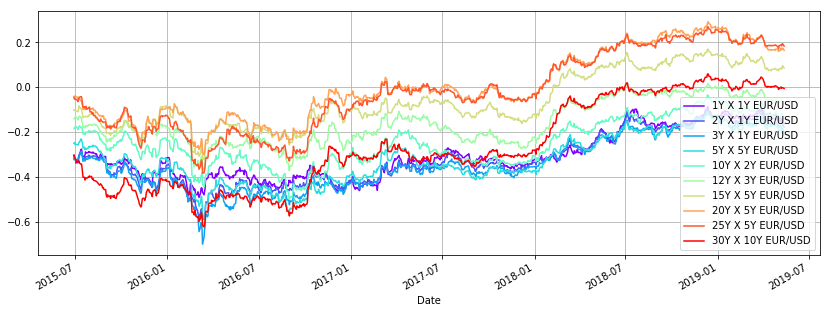

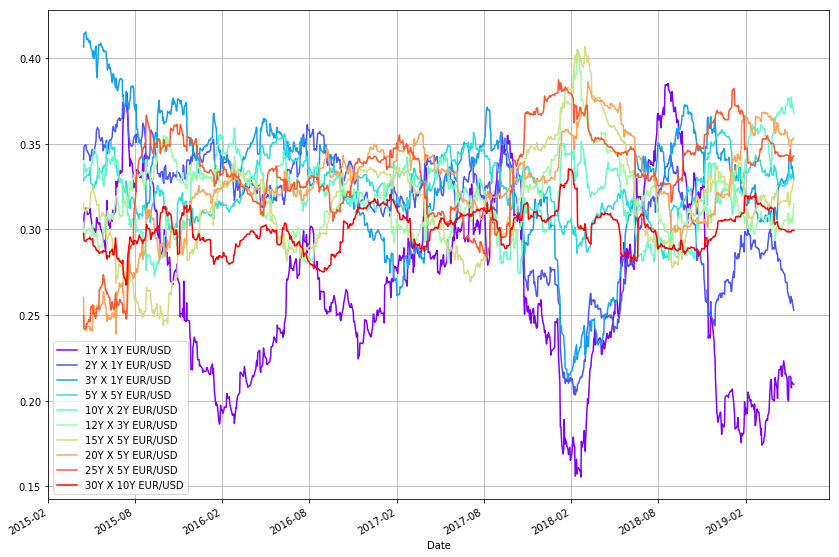

In [10]:
# Data import
dfCross = renameCol(csv2df('eurusdFwdnew.csv'),' Basis Fwd Swap Spread')
dfCross = dfCross.dropna() / 100 # XCCY basis values already in bps
cols = dfCross.shape[1]

n = 1000
ax3 = pcaPlot(dfCross,n,0,'',(14,5))
ax4 = pcaPlot(pcaRun(dfCross),n)
plt.legend(loc='lower left')
print(dfCross.shape[0])
plt.show()

In [7]:
dfSpot = csv2df('spotEURmaster.csv')
dfSpotpca = pcaRun(dfSpot)
print(dfSpotpca.shape[0], dfSpotpca.shape[1])

6929 17


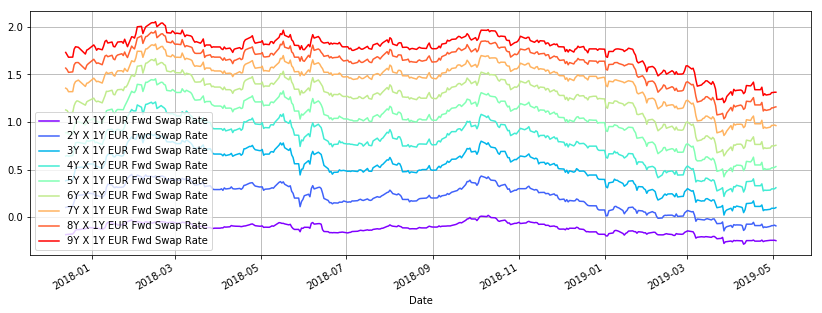

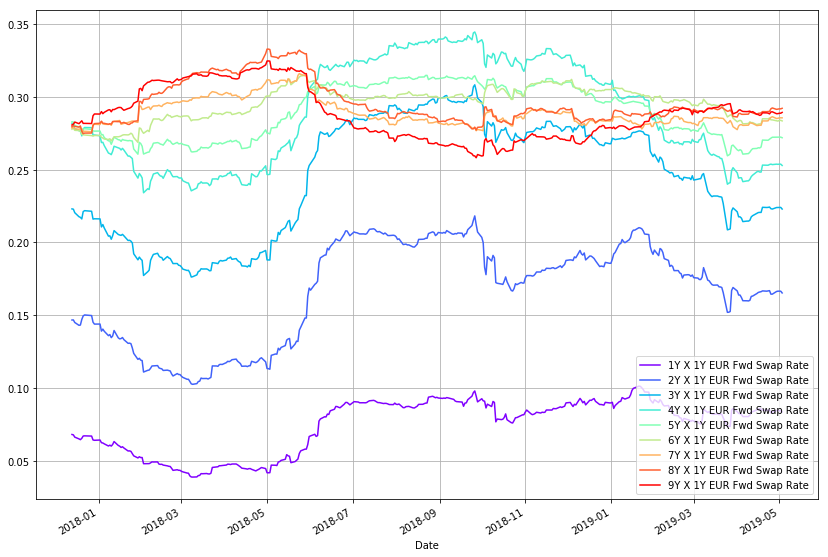

In [15]:
n = 360
fSize = (14,5)
ax1 = pcaPlot(dfGap,n,0,9,fSize)
ax2 = pcaPlot(dfGappca,n,0,9)
plt.show()

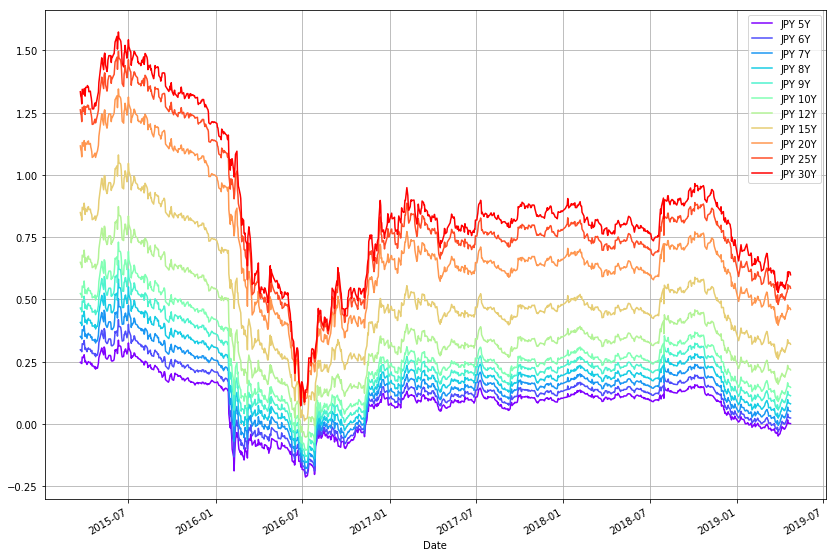

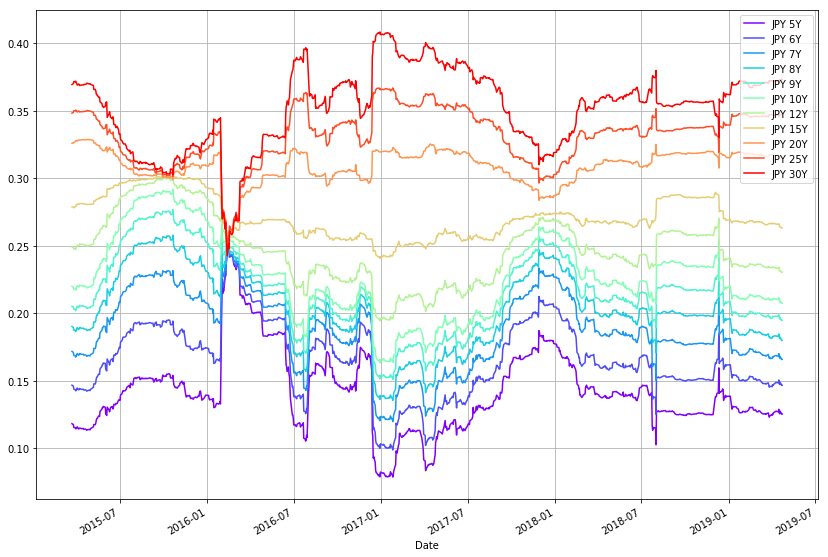

In [8]:
dfJPY = dfRename(csv2df('spotJPYmaster.csv'),' Par Swap Rate')
dfJPYpca = pcaRun(dfJPY)

n = 1000
ax5 = pcaPlot(dfJPY,n,4,15)
ax6 = pcaPlot(dfJPYpca,n,4,15)
plt.show()

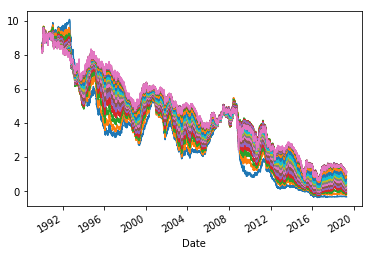

7396

In [60]:
dfSpot.plot(legend=None)
plt.show()
dfSpot.shape[0]

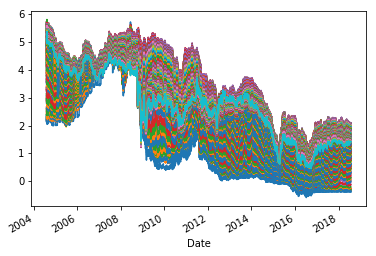

In [75]:
dflol = importFile('fwdEUR.csv')
dflol.plot(legend=False)
plt.show()

In [70]:
# PC analysis using yield levels not returns

dfRates = dfRename(csv2df('fwdEURsmall.csv'))
dfRates = dfRates.dropna()
cols = dfRates.shape[1]

n = 90
m = 300
trainSet = dfRates.iloc[dfRates.shape[0]-n-m:dfRates.shape[0]-n]
testSet = dfRates.iloc[dfRates.shape[0]-n:]

pca = PCA(n_components=3) #n_components=3

pca.fit(trainSet)
eigenValue = pca.explained_variance_ratio_ # How much variance in data is explained by PCs
eigenVectors = pca.components_
scoresFull = pca.fit_transform(trainSet)

pca.fit(trainSet)
outSample = pca.transform(testSet)

In [58]:
#trainSet.head()
#testSet.tail()

[ 0.7542681   0.17888248  0.0356389 ]


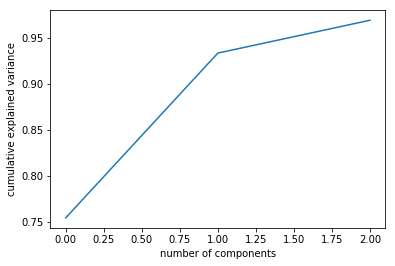

In [77]:
#import seaborn as sns; sns.set()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
print(pca.explained_variance_ratio_)
plt.show()

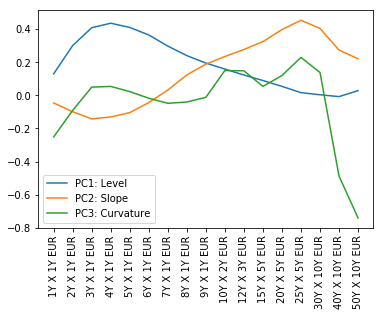

In [74]:
d = {'PC1: Level' : eigenVectors[0],
     'PC2: Slope' : eigenVectors[1],
     'PC3: Curvature' : eigenVectors[2]}

#header = dfRets.columns.get_values()

a = {'mats' : dfRates.columns.get_values()}
dfHead = pd.DataFrame(a)

df3PCs = pd.DataFrame(d)
ax = df3PCs.plot()
ax.set_xticks(df3PCs.index)
ax.set_xticklabels(dfHead.mats)
plt.xticks(rotation=90)
plt.show()

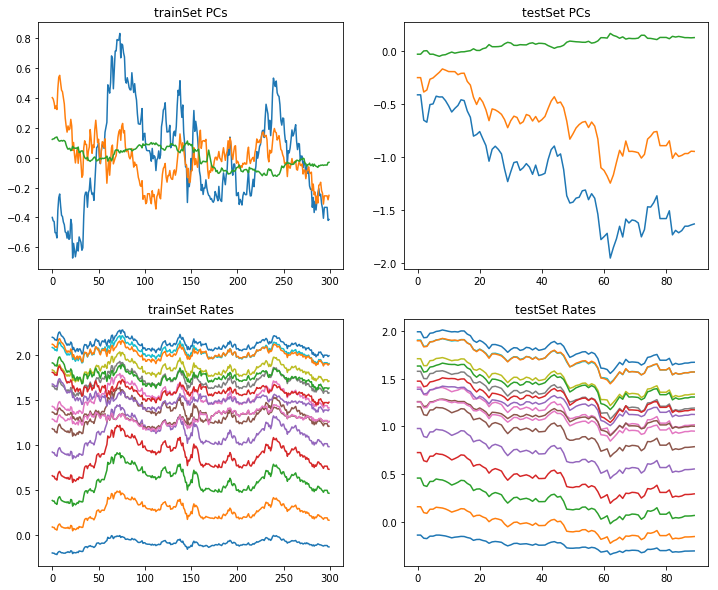

In [75]:
#Plotting results of above test

fig = plt.figure(figsize=(12,10)) #figsize=(12,10)
fig.add_axes()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1.plot(scoresFull)
ax1.set_title('trainSet PCs')
ax2.plot(outSample)
ax2.set_title('testSet PCs')
ax3.plot(pca.inverse_transform(scoresFull))
ax3.set_title('trainSet Rates')
ax4.plot(pca.inverse_transform(outSample))
ax4.set_title('testSet Rates')

plt.show()

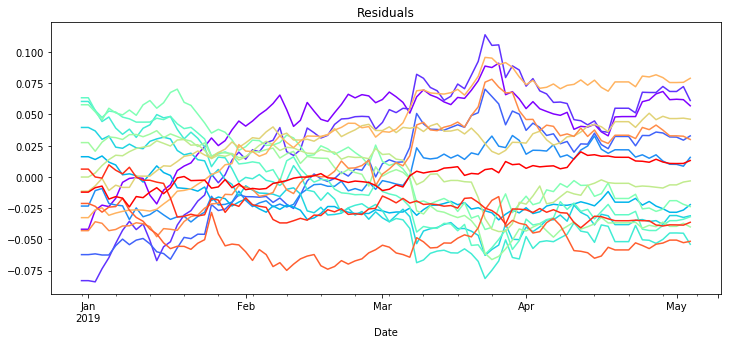

In [76]:
# Residuals
# Note: as we fit our model based on first and second moments (mean and variance), our the predictive power
# of our model decreases drastically when these underlying params shift ie an increase in volatility
# It may be interest to analyse which residuals retrace over time and which don't, the latter pointing
# to a structural shift

# Identify regime -> select model -> evaluate residuals

reconOut = pca.inverse_transform(outSample)
resid = testSet - reconOut

#resid.iloc[resid.shape[0]-3:].plot(kind='bar',grid=False,colormap='rainbow',legend=False,figsize=(12,3))
resid.plot(legend=False,colormap='rainbow',figsize=(12,5),title='Residuals')
plt.show()

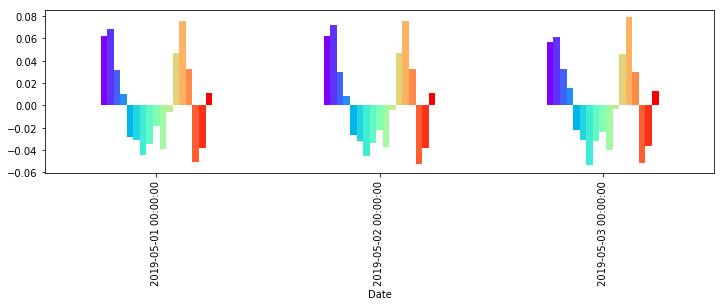

In [61]:
resid.iloc[resid.shape[0]-3:].plot(kind='bar',grid=False,colormap='rainbow',legend=False,figsize=(12,3))
plt.show()

In [35]:
print(pca.mean_,'\n',dfRates.mean(axis=0)) # Why are these different?

[-0.07529071  0.26274513  0.58904001  0.87170368  1.12619209  1.35503033
  1.55117756  1.71441022  1.840489    2.02235289  2.10154156  2.00392589
  1.73110889  1.56002522  1.46142967  1.33585256  1.32879333] 
 1Y X 1Y EUR      1.627944
2Y X 1Y EUR      1.963303
3Y X 1Y EUR      2.290180
4Y X 1Y EUR      2.582293
5Y X 1Y EUR      2.842833
6Y X 1Y EUR      3.069257
7Y X 1Y EUR      3.254917
8Y X 1Y EUR      3.401856
9Y X 1Y EUR      3.520063
10Y X 2Y EUR     3.684058
12Y X 3Y EUR     3.739936
15Y X 5Y EUR     3.548495
20Y X 5Y EUR     3.198077
25Y X 5Y EUR     2.959967
30Y X 10Y EUR    2.898726
40Y X 10Y EUR    2.831089
50Y X 10Y EUR    2.814550
dtype: float64


In [37]:
# PC Analysis (static) // legacy code

dfGap = csv2df('spotEUR.csv')
dfRets = dfGap.diff()*100 # First row is NaN, needs to be dropped
dfRets = dfRets.dropna()
cols = dfRets.shape[1]

n = 200
trainSet = dfRets.iloc[dfRets.shape[0]-(2*n):dfRets.shape[0]-n]
testSet = dfRets.iloc[dfRets.shape[0]-n:]

pca = PCA(n_components=3)

pca.fit(trainSet)
eigenValue = pca.explained_variance_ratio_ # How much variance in data is explained by PCs
eigenVectors = pca.components_
scoresFull = pca.fit_transform(trainSet)
print(scoresFull)

[[ -2.74035151e+00  -4.08295597e+00   2.86619198e+00]
 [  1.05390179e+01  -2.68114025e+00   1.06717155e-01]
 [ -1.82159444e-01  -2.18234707e+00  -4.78069238e-01]
 [ -4.89320384e+00   7.72278976e-01   7.25924785e-01]
 [  9.63960791e+00   1.70503567e+00  -4.26428085e-01]
 [  1.29887968e+01  -7.28228237e-01  -3.94428675e-01]
 [  2.06262184e+01  -2.12196019e+00   1.67932687e-02]
 [ -2.02124074e+01   1.98341933e+00   7.49252399e-01]
 [  7.30021867e+00   4.45172173e-01  -1.27352584e+00]
 [  2.02879630e+01   4.53786936e-01  -3.95998832e-01]
 [  7.50288276e+00   1.11063182e+00  -3.96618217e-01]
 [ -9.59859085e+00   3.96358857e+00  -1.52472127e-01]
 [ -2.81237716e+00   3.09333206e-01  -8.11793910e-02]
 [ -1.89089383e+00  -1.82937662e-01  -7.95133736e-01]
 [  1.36676771e+01  -2.80076728e+00   6.80911009e-01]
 [ -1.76999007e+01   1.77621859e+00  -4.04444999e-01]
 [  1.30225626e-01  -1.18884718e+00   2.07882157e-01]
 [ -5.85740915e+00  -1.38012280e+00   8.45462332e-01]
 [ -2.22608136e+00   1.51368

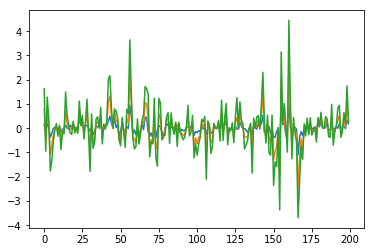

In [48]:
pca.fit(trainSet)
outSample = pca.transform(testSet)

plt.plot(pca.inverse_transform(outSample)[:,0:3])
plt.show()

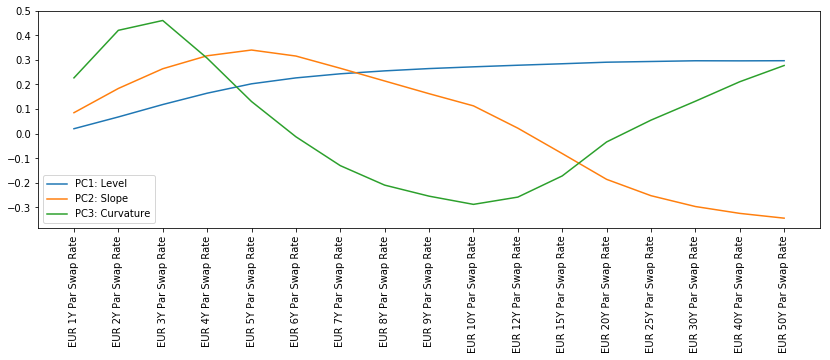

In [26]:
d = {'PC1: Level' : eigenVectors[0],
     'PC2: Slope' : eigenVectors[1],
     'PC3: Curvature' : eigenVectors[2]}

#header = dfRets.columns.get_values()

a = {'mats' : dfRets.columns.get_values()}
dfHead = pd.DataFrame(a)

df3PCs = pd.DataFrame(d)
ax = df3PCs.plot(figsize=(14,4))
ax.set_xticks(df3PCs.index)
ax.set_xticklabels(dfHead.mats)
plt.xticks(rotation=90)
plt.show()

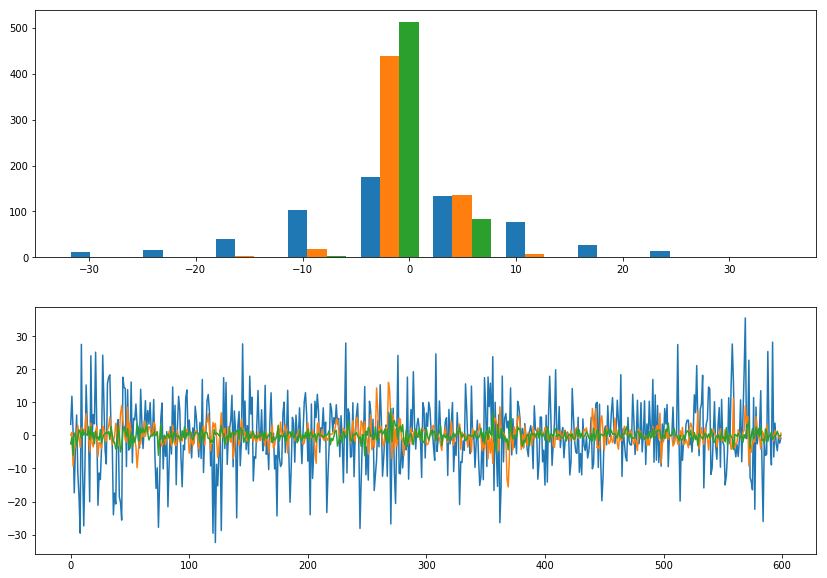

In [61]:
loadings = eigenVectors[:,0:3]
scores = scoresFull[:,0:3] # Maybe these arent the scores

fig = plt.figure(figsize=(14,10))
fig.add_axes()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.hist(scores[:,0:3])
ax2.plot(scores)
plt.show()

# Legacy code

In [ ]:
# PC Analysis (rolling window) // legacy code

def pcaRunOld(dfPar, inclVal=False):
    
    dfRets = dfPar.diff()*100 # Daily returns in bps
    dfRets = dfRets.dropna() # First row is NaN, gets dropped, any others too
    
    from scipy import stats
    dfRets_o = dfRets[(np.abs(stats.zscore(dfRets)) < 3).all(axis=1)] # Remove 3 sigma outliers
    
    cols = dfRets_o.shape[1]
    pca = PCA(n_components=cols)
    
    eigenVal = []
    eigenVec = []

    sampleSize = dfRets_o.shape[0]
    lookbackSize = 90
    
    for i in range(0,(sampleSize-lookbackSize)):
        #print(i,lookbackSize+i)
        pca.fit(dfRets_o.iloc[i:lookbackSize+i])
        eigenVal.append(pca.explained_variance_ratio_)
        eigenVec.append(pca.components_)
        
    return eigenVec # Update to optionally include eigenVal

def pcaPlotOld(eigVec):
    
    pc1 = []
    pc1o = []
    pc2 = []
    pc3 = []
    pc4 = []
    
    for j in range(0,len(eigVec)):
        pc1.append(np.abs(eigVec[j][0][:])) #using abs to solve sign flipping issue
        #pc1o.append(eigenVal[j][:])
        pc2.append(eigVec[j][1][:1])
        pc3.append(eigVec[j][2][:1])
        pc4.append(eigVec[j][3][:1])
    
    return plt.plot(pc1)

In [ ]:
resid = dfRets - np.dot(loadings,scores.T).T - dfRets.mean()
res1 = dfRets - np.dot(loadings,scores.T).T